This notebook goes through the external test set analysis from data parsing to figure / table generation.

Data references:

| **Study Code**   | **DOI**                                    |
|:-----------------|:-------------------------------------------|
| CONMED           | https://doi.org/10.1016/j.knee.2018.07.004 |
| PREOA            | https://doi.org/10.1016/j.bone.2018.03.006 |
| KNEEVAL          | https://doi.org/10.1016/j.jocd.2021.01.004 |


In [2]:
from __future__ import annotations

import sys
import os
import argparse

import pandas as pd
import numpy as np
from scipy import stats

from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns

Define functions to parse microarchitectural data from logs:

In [3]:
def parse_cort_log(data: dict, log_fn: str) -> dict:
    with open(log_fn, encoding="cp1250") as f:
        for line in f:
            if "dt_thickness" in line: break
        for line in f:
            if "!> Th               =" in line:
                parameter = "Sc.Th"
                data[parameter] = line.split()[3]
                data[f"{parameter} units"] = (line.split(None,4)[4]).splitlines(False)[0]
                break
        for line in f:
            if "/voxgobj_scanco_param" in line: break
        for line in f:
            if "!% mean_unit =" in line:
                parameter = 'Sc.BMD'
                data[parameter] = line.split()[3]
                data[f'{parameter} units'] = (line.split(None,4)[4]).splitlines(False)[0]
                break
    return data


def parse_trab_log(data: dict, log_fn: str) -> dict:
    with open(log_fn, encoding="cp1250") as f:
        for line in f:
            if "dt_thickness" in line: break
        for line in f:
            if "!> Th               =" in line:
                parameter = "Tb.Th"
                data[parameter] = line.split()[3]
                data[f"{parameter} units"] = (line.split(None,4)[4]).splitlines(False)[0]
                break
        for line in f:
            if "dt_spacing" in line: break
        for line in f:
            if "!> BG Th            =" in line:
                parameter = 'Tb.Sp'
                data[parameter] = line.split()[4]
                data[f"{parameter} units"] = (line.split(None,5)[5]).splitlines(False)[0]
                break 
        for line in f:
            if "/dt_number" in line: break
        for line in f:
            if "!> MAT N (1/Th)     =" in line:
                parameter = 'Tb.N'
                data[parameter] = line.split()[5]
                data[f'{parameter} units'] = (line.split(None,6)[6]).splitlines(False)[0]
                break
        for line in f:
            if "/voxgobj_scanco_param" in line: break
        for line in f:
            if "!% mean_unit =" in line:
                parameter = 'Tb.BMD'
                data[parameter] = line.split()[3]
                data[f'{parameter} units'] = (line.split(None,4)[4]).splitlines(False)[0]
                break
    return data


def parse_log_file(log_fn: str, parse_metadata: Callable) -> dict:
    data = {}
    data = parse_metadata(data, log_fn)
    if data["roi"] in [16, 17, 36, 37]:
        return parse_cort_log(data, log_fn)
    else:
        return parse_trab_log(data, log_fn)
    

def parse_metadata_conmed(data: dict, log_fn: str) -> dict:
    data["study"] = "CONMED"
    data["roi"] = int(log_fn[-6:-4])
    data["compartment"] = "lateral" if data["roi"]%10 in [6, 0, 1, 2] else "medial"
    data["depth"] = depths[data["roi"]%10]
    data["id"] = int(log_fn[-15:-13])
    data["side"] = log_fn[-13]
    data["bone"] = log_fn[-11]
    return data


def parse_metadata_preoa(data: dict, log_fn: str) -> dict:
    data["study"] = "PREOA"
    data["roi"] = int(log_fn[-6:-4])
    data["compartment"] = "lateral" if data["roi"]%10 in [6, 0, 1, 2] else "medial"
    data["depth"] = depths[data["roi"]%10]
    data["id"] = int(log_fn[-21:-18])
    data["side"] = log_fn[-17]
    data["bone"] = log_fn[-11]
    return data


def parse_metadata_kneeval(data: dict, log_fn: str) -> dict:
    data["study"] = "KNEEVAL"
    data["roi"] = int(log_fn[-6:-4])
    data["compartment"] = "lateral" if data["roi"]%10 in [6, 0, 1, 2] else "medial"
    data["depth"] = depths[data["roi"]%10]
    data["id"] = int(log_fn[-16:-13])
    data["side"] = "?"
    data["bone"] = "F"
    return data


depths = [
    "shallow",
    "middle",
    "deep",
    "shallow",
    "middle",
    "deep",
    "plate",
    "plate"
]

Define a function to compute precision estimates:

In [4]:
def calculate_precision(data: List[np.ndarray], eps = 1e-8, ddof=1) -> Tuple[float, float]:
    
    m = len(data)
    
    means = np.asarray([d.mean() for d in data])
    standard_deviations = np.asarray([d.std(ddof=ddof) for d in data])
    
    rms_pe = np.sqrt(np.sum(standard_deviations**2)/m)
    lsc = 2.77*rms_pe
    
    rms_cv = np.sqrt(np.sum((100 * standard_deviations / (means + eps))**2) / m)
    
    return rms_cv, lsc, rms_pe, standard_deviations

Parse the predicted CONMED morphometry:

In [5]:
conmed_log_fns = glob(os.path.join("..", "vms_logs", "conmed", "pred", "*.LOG"))

df_conmed_pred = pd.DataFrame()

for log_fn in conmed_log_fns:
    data = parse_log_file(log_fn, parse_metadata_conmed)
    df_conmed_pred = df_conmed_pred.append(data, ignore_index=True)
    
df_conmed_pred.drop(
    columns = [c for c in df_conmed_pred.columns if "units" in c],
    inplace = True
)
    
df_conmed_pred

study   roi compartment    depth    id side bone     Sc.Th    Sc.BMD  \
0     CONMED  37.0      medial    plate   8.0    R    T  1.217746  622.1509   
1     CONMED  16.0     lateral    plate  25.0    R    F  0.479529  469.8127   
2     CONMED  33.0      medial  shallow  23.0    L    T       NaN       NaN   
3     CONMED  10.0     lateral  shallow  31.0    R    F       NaN       NaN   
4     CONMED  15.0      medial     deep   6.0    R    F       NaN       NaN   
...      ...   ...         ...      ...   ...  ...  ...       ...       ...   
1115  CONMED  10.0     lateral  shallow   2.0    R    F       NaN       NaN   
1116  CONMED  33.0      medial  shallow  10.0    L    T       NaN       NaN   
1117  CONMED  35.0      medial     deep   4.0    L    T       NaN       NaN   
1118  CONMED  14.0      medial   middle  29.0    L    F       NaN       NaN   
1119  CONMED  16.0     lateral    plate  16.0    R    F  0.749456  612.8694   

        Tb.BMD      Tb.N     Tb.Sp     Tb.Th  
0          NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN  
2     378.4099  2.823537  0.314693  0.296631  
3     340.8801  2.481400  0.388692  0.298901  
4     228.6946  2.091270  0.473425  0.225845  
...        ...       ...       ...       ...  
1115  290.4370  2.658410  0.345979  0.243547  
1116  340.6784  2.585485  0.366099  0.282984  
1117  174.6196  1.663447  0.593940  0.256065  
1118  300.1221  2.531703  0.366818  0.251703  
1119       NaN       NaN       NaN       NaN  

[1120 rows x 13 columns]

Parse the reference CONMED morphometry:

In [6]:
conmed_log_fns = glob(os.path.join("..", "vms_logs", "conmed", "ref", "*.LOG"))

df_conmed_ref = pd.DataFrame()

for log_fn in conmed_log_fns:
    data = parse_log_file(log_fn, parse_metadata_conmed)
    df_conmed_ref = df_conmed_ref.append(data, ignore_index=True)
    
df_conmed_ref.drop(
    columns = [c for c in df_conmed_ref.columns if "units" in c],
    inplace = True
)
    
df_conmed_ref

study   roi compartment    depth    id side bone     Sc.Th    Sc.BMD  \
0     CONMED  37.0      medial    plate   8.0    R    T  1.895573  637.4857   
1     CONMED  16.0     lateral    plate  25.0    R    F  0.253843  557.3820   
2     CONMED  33.0      medial  shallow  23.0    L    T       NaN       NaN   
3     CONMED  10.0     lateral  shallow  31.0    R    F       NaN       NaN   
4     CONMED  15.0      medial     deep   6.0    R    F       NaN       NaN   
...      ...   ...         ...      ...   ...  ...  ...       ...       ...   
1115  CONMED  10.0     lateral  shallow   2.0    R    F       NaN       NaN   
1116  CONMED  33.0      medial  shallow  10.0    L    T       NaN       NaN   
1117  CONMED  35.0      medial     deep   4.0    L    T       NaN       NaN   
1118  CONMED  14.0      medial   middle  29.0    L    F       NaN       NaN   
1119  CONMED  16.0     lateral    plate  16.0    R    F  0.705701  687.3234   

        Tb.BMD      Tb.N     Tb.Sp     Tb.Th  
0          NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN  
2     422.3962  2.829645  0.288038  0.329180  
3     367.9177  2.537302  0.350378  0.321750  
4     227.2822  2.051763  0.482516  0.220638  
...        ...       ...       ...       ...  
1115  302.3416  2.573980  0.356342  0.260142  
1116  375.3832  2.712133  0.324377  0.309792  
1117  181.6817  1.647803  0.599411  0.257273  
1118  303.9558  2.579662  0.355920  0.252320  
1119       NaN       NaN       NaN       NaN  

[1120 rows x 13 columns]

Parse the predicted PREOA directory:

In [7]:
preoa_log_fns = glob(os.path.join("..", "vms_logs", "preoa", "pred", "*.LOG"))

df_preoa_pred = pd.DataFrame()

for log_fn in preoa_log_fns:
    data = parse_log_file(log_fn, parse_metadata_preoa)
    df_preoa_pred = df_preoa_pred.append(data, ignore_index=True)
    
df_preoa_pred.drop(
    columns = [c for c in df_preoa_pred.columns if "units" in c],
    inplace = True
)
    
df_preoa_pred

study   roi compartment    depth    id side bone     Tb.Th     Tb.Sp  \
0    PREOA  11.0     lateral   middle  24.0    R    F  0.240336  0.340117   
1    PREOA  17.0      medial    plate  25.0    R    F       NaN       NaN   
2    PREOA  33.0      medial  shallow  20.0    L    T  0.339172  0.381420   
3    PREOA  35.0      medial     deep  21.0    L    T  0.243271  0.565968   
4    PREOA  32.0     lateral     deep  33.0    R    T  0.223680  0.483606   
..     ...   ...         ...      ...   ...  ...  ...       ...       ...   
859  PREOA  36.0     lateral    plate  19.0    L    T       NaN       NaN   
860  PREOA  12.0     lateral     deep  13.0    L    F  0.252746  0.399649   
861  PREOA  36.0     lateral    plate  16.0    R    T       NaN       NaN   
862  PREOA  30.0     lateral  shallow  17.0    R    T  0.272978  0.316693   
863  PREOA  37.0      medial    plate   5.0    L    T       NaN       NaN   

         Tb.N    Tb.BMD    Sc.BMD     Sc.Th  
0    2.592167  290.1857       NaN       NaN  
1         NaN       NaN  601.7061  0.554019  
2    2.401807  381.5109       NaN       NaN  
3    1.730877  186.8868       NaN       NaN  
4    2.006007  187.4957       NaN       NaN  
..        ...       ...       ...       ...  
859       NaN       NaN  603.1266  1.126244  
860  2.384246  256.2939       NaN       NaN  
861       NaN       NaN  523.7753  0.759305  
862  2.820867  332.8041       NaN       NaN  
863       NaN       NaN  654.4717  1.244970  

[864 rows x 13 columns]

Parse the reference PREOA directory:

In [8]:
preoa_log_fns = glob(os.path.join("..", "vms_logs", "preoa", "ref", "*.LOG"))

df_preoa_ref = pd.DataFrame()

for log_fn in preoa_log_fns:
    data = parse_log_file(log_fn, parse_metadata_preoa)
    df_preoa_ref = df_preoa_ref.append(data, ignore_index=True)
    
df_preoa_ref.drop(
    columns = [c for c in df_preoa_ref.columns if "units" in c],
    inplace = True
)
    
df_preoa_ref

study   roi compartment    depth    id side bone     Tb.Th     Tb.Sp  \
0    PREOA  11.0     lateral   middle  24.0    R    F  0.238435  0.344757   
1    PREOA  17.0      medial    plate  25.0    R    F       NaN       NaN   
2    PREOA  33.0      medial  shallow  20.0    L    T  0.360634  0.358478   
3    PREOA  35.0      medial     deep  21.0    L    T  0.239090  0.578299   
4    PREOA  32.0     lateral     deep  33.0    R    T  0.224582  0.491557   
..     ...   ...         ...      ...   ...  ...  ...       ...       ...   
859  PREOA  36.0     lateral    plate  19.0    L    T       NaN       NaN   
860  PREOA  12.0     lateral     deep  13.0    L    F  0.252957  0.400524   
861  PREOA  36.0     lateral    plate  16.0    R    T       NaN       NaN   
862  PREOA  30.0     lateral  shallow  17.0    R    T  0.292192  0.327457   
863  PREOA  37.0      medial    plate   5.0    L    T       NaN       NaN   

         Tb.N    Tb.BMD    Sc.BMD     Sc.Th  
0    2.559465  285.7209       NaN       NaN  
1         NaN       NaN  697.9019  0.367095  
2    2.415310  405.8643       NaN       NaN  
3    1.694600  178.9720       NaN       NaN  
4    1.975495  188.9163       NaN       NaN  
..        ...       ...       ...       ...  
859       NaN       NaN  642.7009  1.465244  
860  2.379124  256.2939       NaN       NaN  
861       NaN       NaN  536.5608  0.509410  
862  2.721735  341.1249       NaN       NaN  
863       NaN       NaN  667.0543  1.470127  

[864 rows x 13 columns]

Parse the predicted KNEEVAL directory:

In [9]:
kneeval_log_fns = glob(os.path.join("..", "vms_logs", "kneeval", "pred", "*.LOG"))

if False:
    print(kneeval_log_fns[0])
    for i, c in enumerate(kneeval_log_fns[0]):
        z = -len(kneeval_log_fns[0]) + i
        print(f"{z:3d}: {c}")

df_kneeval_pred = pd.DataFrame()

for log_fn in kneeval_log_fns:
    data = parse_log_file(log_fn, parse_metadata_kneeval)
    df_kneeval_pred = df_kneeval_pred.append(data, ignore_index=True)
    
df_kneeval_pred.drop(
    columns = [c for c in df_kneeval_pred.columns if "units" in c],
    inplace = True
)
    
df_kneeval_pred

study   roi compartment    depth    id side bone     Tb.Th     Tb.Sp  \
0   KNEEVAL  10.0     lateral  shallow  13.0    ?    F  0.261634  0.431220   
1   KNEEVAL  13.0      medial  shallow  30.0    ?    F  0.309207  0.336536   
2   KNEEVAL  11.0     lateral   middle   6.0    ?    F  0.237570  0.440179   
3   KNEEVAL  17.0      medial    plate  12.0    ?    F       NaN       NaN   
4   KNEEVAL  10.0     lateral  shallow   6.0    ?    F  0.253385  0.400908   
..      ...   ...         ...      ...   ...  ...  ...       ...       ...   
91  KNEEVAL  15.0      medial     deep   2.0    ?    F  0.222110  0.424125   
92  KNEEVAL  14.0      medial   middle   2.0    ?    F  0.244017  0.367132   
93  KNEEVAL  10.0     lateral  shallow  27.0    ?    F  0.285258  0.360770   
94  KNEEVAL  13.0      medial  shallow   3.0    ?    F  0.284364  0.366619   
95  KNEEVAL  10.0     lateral  shallow  20.0    ?    F  0.257746  0.379105   

        Tb.N    Tb.BMD    Sc.BMD     Sc.Th  
0   2.077276  289.5819       NaN       NaN  
1   2.507548  394.1082       NaN       NaN  
2   2.129196  262.1780       NaN       NaN  
3        NaN       NaN  728.8271  0.465106  
4   2.348206  306.2200       NaN       NaN  
..       ...       ...       ...       ...  
91  2.216360  243.7783       NaN       NaN  
92  2.408613  290.9521       NaN       NaN  
93  2.435122  368.4660       NaN       NaN  
94  2.386247  351.8279       NaN       NaN  
95  2.273616  311.7008       NaN       NaN  

[96 rows x 13 columns]

Parse the reference KNEEVAL directory:

In [10]:
kneeval_log_fns = glob(os.path.join("..", "vms_logs", "kneeval", "ref", "*.LOG"))

df_kneeval_ref = pd.DataFrame()

for log_fn in kneeval_log_fns:
    data = parse_log_file(log_fn, parse_metadata_kneeval)
    df_kneeval_ref = df_kneeval_ref.append(data, ignore_index=True)
    
df_kneeval_ref.drop(
    columns = [c for c in df_kneeval_ref.columns if "units" in c],
    inplace = True
)
    
df_kneeval_ref

study   roi compartment    depth    id side bone     Tb.Th     Tb.Sp  \
0   KNEEVAL  10.0     lateral  shallow  13.0    ?    F  0.270145  0.435636   
1   KNEEVAL  13.0      medial  shallow  30.0    ?    F  0.349811  0.290391   
2   KNEEVAL  11.0     lateral   middle   6.0    ?    F  0.233415  0.447006   
3   KNEEVAL  17.0      medial    plate  12.0    ?    F       NaN       NaN   
4   KNEEVAL  10.0     lateral  shallow   6.0    ?    F  0.262735  0.408921   
..      ...   ...         ...      ...   ...  ...  ...       ...       ...   
91  KNEEVAL  15.0      medial     deep   2.0    ?    F  0.219579  0.421646   
92  KNEEVAL  14.0      medial   middle   2.0    ?    F  0.244909  0.357390   
93  KNEEVAL  10.0     lateral  shallow  27.0    ?    F  0.302616  0.324744   
94  KNEEVAL  13.0      medial  shallow   3.0    ?    F  0.292851  0.409801   
95  KNEEVAL  10.0     lateral  shallow  20.0    ?    F  0.259617  0.388825   

        Tb.N    Tb.BMD    Sc.BMD     Sc.Th  
0   2.051339  297.6073       NaN       NaN  
1   2.540125  433.4523       NaN       NaN  
2   2.107293  255.5228       NaN       NaN  
3        NaN       NaN  792.8348  0.424302  
4   2.309994  310.3305       NaN       NaN  
..       ...       ...       ...       ...  
91  2.214883  242.0166       NaN       NaN  
92  2.434990  293.3010       NaN       NaN  
93  2.495256  404.2868       NaN       NaN  
94  2.233094  341.4536       NaN       NaN  
95  2.206422  307.9817       NaN       NaN  

[96 rows x 13 columns]

Append all of the predicted morphometry into one big dataframe:

In [11]:
df_pred = df_conmed_pred.append(df_preoa_pred, ignore_index=True).append(df_kneeval_pred, ignore_index=True)

df_pred

study   roi compartment    depth    id side bone     Sc.Th    Sc.BMD  \
0      CONMED  37.0      medial    plate   8.0    R    T  1.217746  622.1509   
1      CONMED  16.0     lateral    plate  25.0    R    F  0.479529  469.8127   
2      CONMED  33.0      medial  shallow  23.0    L    T       NaN       NaN   
3      CONMED  10.0     lateral  shallow  31.0    R    F       NaN       NaN   
4      CONMED  15.0      medial     deep   6.0    R    F       NaN       NaN   
...       ...   ...         ...      ...   ...  ...  ...       ...       ...   
2075  KNEEVAL  15.0      medial     deep   2.0    ?    F       NaN       NaN   
2076  KNEEVAL  14.0      medial   middle   2.0    ?    F       NaN       NaN   
2077  KNEEVAL  10.0     lateral  shallow  27.0    ?    F       NaN       NaN   
2078  KNEEVAL  13.0      medial  shallow   3.0    ?    F       NaN       NaN   
2079  KNEEVAL  10.0     lateral  shallow  20.0    ?    F       NaN       NaN   

        Tb.BMD      Tb.N     Tb.Sp     Tb.Th  
0          NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN  
2     378.4099  2.823537  0.314693  0.296631  
3     340.8801  2.481400  0.388692  0.298901  
4     228.6946  2.091270  0.473425  0.225845  
...        ...       ...       ...       ...  
2075  243.7783  2.216360  0.424125  0.222110  
2076  290.9521  2.408613  0.367132  0.244017  
2077  368.4660  2.435122  0.360770  0.285258  
2078  351.8279  2.386247  0.366619  0.284364  
2079  311.7008  2.273616  0.379105  0.257746  

[2080 rows x 13 columns]

Append all of the reference morphometry into one big dataframe:

In [12]:
df_ref = df_conmed_ref.append(df_preoa_ref, ignore_index=True).append(df_kneeval_ref, ignore_index=True)

df_ref

study   roi compartment    depth    id side bone     Sc.Th    Sc.BMD  \
0      CONMED  37.0      medial    plate   8.0    R    T  1.895573  637.4857   
1      CONMED  16.0     lateral    plate  25.0    R    F  0.253843  557.3820   
2      CONMED  33.0      medial  shallow  23.0    L    T       NaN       NaN   
3      CONMED  10.0     lateral  shallow  31.0    R    F       NaN       NaN   
4      CONMED  15.0      medial     deep   6.0    R    F       NaN       NaN   
...       ...   ...         ...      ...   ...  ...  ...       ...       ...   
2075  KNEEVAL  15.0      medial     deep   2.0    ?    F       NaN       NaN   
2076  KNEEVAL  14.0      medial   middle   2.0    ?    F       NaN       NaN   
2077  KNEEVAL  10.0     lateral  shallow  27.0    ?    F       NaN       NaN   
2078  KNEEVAL  13.0      medial  shallow   3.0    ?    F       NaN       NaN   
2079  KNEEVAL  10.0     lateral  shallow  20.0    ?    F       NaN       NaN   

        Tb.BMD      Tb.N     Tb.Sp     Tb.Th  
0          NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN  
2     422.3962  2.829645  0.288038  0.329180  
3     367.9177  2.537302  0.350378  0.321750  
4     227.2822  2.051763  0.482516  0.220638  
...        ...       ...       ...       ...  
2075  242.0166  2.214883  0.421646  0.219579  
2076  293.3010  2.434990  0.357390  0.244909  
2077  404.2868  2.495256  0.324744  0.302616  
2078  341.4536  2.233094  0.409801  0.292851  
2079  307.9817  2.206422  0.388825  0.259617  

[2080 rows x 13 columns]

This data is in what you might call "super long" format where every ROI gets its own row.

Now we can join the two dataframes and start analyzing.

In [13]:
parameters = ["Sc.BMD", "Sc.Th", "Tb.BMD", "Tb.Th", "Tb.N", "Tb.Sp"]

ref_parameters = {p: f"Reference {p}" for p in parameters}
pred_parameters = {p: f"Predicted {p}" for p in parameters}

df_ref.rename(columns=ref_parameters, inplace=True)
df_pred.rename(columns=pred_parameters, inplace=True)

df = df_ref.merge(df_pred, on=["study", "id", "side", "bone", "compartment", "depth", "roi"])

for p in list(ref_parameters.values()) + list(pred_parameters.values()):
    df[p] = df[p].apply(float)

df

study   roi compartment    depth    id side bone  Reference Sc.Th  \
0      CONMED  37.0      medial    plate   8.0    R    T         1.895573   
1      CONMED  16.0     lateral    plate  25.0    R    F         0.253843   
2      CONMED  33.0      medial  shallow  23.0    L    T              NaN   
3      CONMED  10.0     lateral  shallow  31.0    R    F              NaN   
4      CONMED  15.0      medial     deep   6.0    R    F              NaN   
...       ...   ...         ...      ...   ...  ...  ...              ...   
2075  KNEEVAL  15.0      medial     deep   2.0    ?    F              NaN   
2076  KNEEVAL  14.0      medial   middle   2.0    ?    F              NaN   
2077  KNEEVAL  10.0     lateral  shallow  27.0    ?    F              NaN   
2078  KNEEVAL  13.0      medial  shallow   3.0    ?    F              NaN   
2079  KNEEVAL  10.0     lateral  shallow  20.0    ?    F              NaN   

      Reference Sc.BMD  Reference Tb.BMD  Reference Tb.N  Reference Tb.Sp  \
0             637.4857               NaN             NaN              NaN   
1             557.3820               NaN             NaN              NaN   
2                  NaN          422.3962        2.829645         0.288038   
3                  NaN          367.9177        2.537302         0.350378   
4                  NaN          227.2822        2.051763         0.482516   
...                ...               ...             ...              ...   
2075               NaN          242.0166        2.214883         0.421646   
2076               NaN          293.3010        2.434990         0.357390   
2077               NaN          404.2868        2.495256         0.324744   
2078               NaN          341.4536        2.233094         0.409801   
2079               NaN          307.9817        2.206422         0.388825   

      Reference Tb.Th  Predicted Sc.Th  Predicted Sc.BMD  Predicted Tb.BMD  \
0                 NaN         1.217746          622.1509               NaN   
1                 NaN         0.479529          469.8127               NaN   
2            0.329180              NaN               NaN          378.4099   
3            0.321750              NaN               NaN          340.8801   
4            0.220638              NaN               NaN          228.6946   
...               ...              ...               ...               ...   
2075         0.219579              NaN               NaN          243.7783   
2076         0.244909              NaN               NaN          290.9521   
2077         0.302616              NaN               NaN          368.4660   
2078         0.292851              NaN               NaN          351.8279   
2079         0.259617              NaN               NaN          311.7008   

      Predicted Tb.N  Predicted Tb.Sp  Predicted Tb.Th  
0                NaN              NaN              NaN  
1                NaN              NaN              NaN  
2           2.823537         0.314693         0.296631  
3           2.481400         0.388692         0.298901  
4           2.091270         0.473425         0.225845  
...              ...              ...              ...  
2075        2.216360         0.424125         0.222110  
2076        2.408613         0.367132         0.244017  
2077        2.435122         0.360770         0.285258  
2078        2.386247         0.366619         0.284364  
2079        2.273616         0.379105         0.257746  

[2080 rows x 19 columns]

Calculate means and differences for Bland Altman plots.

In [14]:
for p in parameters:
    df[f"Mean {p}"] = (df[f"Reference {p}"] + df[f"Predicted {p}"] ) / 2
    df[f"Difference {p} (Pred. - Ref.)"] = df[f"Predicted {p}"] - df[f"Reference {p}"]

Load in the motion scores:

In [15]:
motion_conmed = pd.read_excel(os.path.join("~", "Documents", "Data", "MotionScores", "conmed.xlsx"))
motion_preoa = pd.read_excel(os.path.join("~", "Documents", "Data", "MotionScores", "preoa.xlsx"))

motion_conmed["study"] = "CONMED"
motion_preoa["study"] = "PREOA"

motion = motion_conmed.append(motion_preoa)

motion = pd.melt(
    motion,
    id_vars=["ID", "study"],
    var_name="site",
    value_name="motion score"
)
motion["side"] = motion["site"].apply(lambda x: "L" if "Left" in x else "R")
motion["bone"] = motion["site"].apply(lambda x: "T" if "Tibia" in x else "F")

motion.drop(columns=["site"], inplace=True)
motion.rename(columns={"ID":"id"}, inplace=True)

motion

id   study  motion score side bone
0     1  CONMED             2    L    F
1     2  CONMED             1    L    F
2     3  CONMED             4    L    F
3     4  CONMED             1    L    F
4     5  CONMED             1    L    F
..   ..     ...           ...  ...  ...
251  29   PREOA             2    R    T
252  30   PREOA             2    R    T
253  31   PREOA             2    R    T
254  32   PREOA             4    R    T
255  33   PREOA             2    R    T

[256 rows x 5 columns]

Now merge the motion scores into the main dataframe.

In [16]:
df = pd.merge(left=df, right=motion, how="left", on=["id", "study", "side", "bone"])

df

study   roi compartment    depth    id side bone  Reference Sc.Th  \
0      CONMED  37.0      medial    plate   8.0    R    T         1.895573   
1      CONMED  16.0     lateral    plate  25.0    R    F         0.253843   
2      CONMED  33.0      medial  shallow  23.0    L    T              NaN   
3      CONMED  10.0     lateral  shallow  31.0    R    F              NaN   
4      CONMED  15.0      medial     deep   6.0    R    F              NaN   
...       ...   ...         ...      ...   ...  ...  ...              ...   
2075  KNEEVAL  15.0      medial     deep   2.0    ?    F              NaN   
2076  KNEEVAL  14.0      medial   middle   2.0    ?    F              NaN   
2077  KNEEVAL  10.0     lateral  shallow  27.0    ?    F              NaN   
2078  KNEEVAL  13.0      medial  shallow   3.0    ?    F              NaN   
2079  KNEEVAL  10.0     lateral  shallow  20.0    ?    F              NaN   

      Reference Sc.BMD  Reference Tb.BMD  ...  \
0             637.4857               NaN  ...   
1             557.3820               NaN  ...   
2                  NaN          422.3962  ...   
3                  NaN          367.9177  ...   
4                  NaN          227.2822  ...   
...                ...               ...  ...   
2075               NaN          242.0166  ...   
2076               NaN          293.3010  ...   
2077               NaN          404.2868  ...   
2078               NaN          341.4536  ...   
2079               NaN          307.9817  ...   

      Difference Sc.Th (Pred. - Ref.)  Mean Tb.BMD  \
0                           -0.677827          NaN   
1                            0.225686          NaN   
2                                 NaN    400.40305   
3                                 NaN    354.39890   
4                                 NaN    227.98840   
...                               ...          ...   
2075                              NaN    242.89745   
2076                              NaN    292.12655   
2077                              NaN    386.37640   
2078                              NaN    346.64075   
2079                              NaN    309.84125   

      Difference Tb.BMD (Pred. - Ref.)  Mean Tb.Th  \
0                                  NaN         NaN   
1                                  NaN         NaN   
2                             -43.9863    0.312905   
3                             -27.0376    0.310325   
4                               1.4124    0.223241   
...                                ...         ...   
2075                            1.7617    0.220844   
2076                           -2.3489    0.244463   
2077                          -35.8208    0.293937   
2078                           10.3743    0.288608   
2079                            3.7191    0.258682   

      Difference Tb.Th (Pred. - Ref.)  Mean Tb.N  \
0                                 NaN        NaN   
1                                 NaN        NaN   
2                           -0.032549   2.826591   
3                           -0.022849   2.509351   
4                            0.005207   2.071516   
...                               ...        ...   
2075                         0.002531   2.215622   
2076                        -0.000892   2.421801   
2077                        -0.017358   2.465189   
2078                        -0.008487   2.309671   
2079                        -0.001871   2.240019   

      Difference Tb.N (Pred. - Ref.)  Mean Tb.Sp  \
0                                NaN         NaN   
1                                NaN         NaN   
2                          -0.006108    0.301366   
3                          -0.055902    0.369535   
4                           0.039507    0.477970   
...                              ...         ...   
2075                        0.001477    0.422886   
2076                       -0.026377    0.362261   
2077                       -0.060134    0.342757   
2078                        0.153153    0.388210   

Finally, verify we have numeric motion scores for CONMED and PREOA, but not for KNEEVAL.

NOTE: KNEEVAL is a cadaver study so the knees were not moving while being imaged.

In [17]:
for study in ["CONMED", "PREOA", "KNEEVAL"]:

    num_total = len(df[df["study"]==study])
    num_na = df[df["study"]==study]["motion score"].isna().sum()
    
    print(f"Study: {study:8s} | # samples: {num_total:6d}, # N/A motion scores: {num_na:5d}")

Study: CONMED   | # samples:   1120, # N/A motion scores:     0
Study: PREOA    | # samples:    864, # N/A motion scores:     0
Study: KNEEVAL  | # samples:     96, # N/A motion scores:    96


Looks good.

Linear Correlation and Bland-Altman plots:

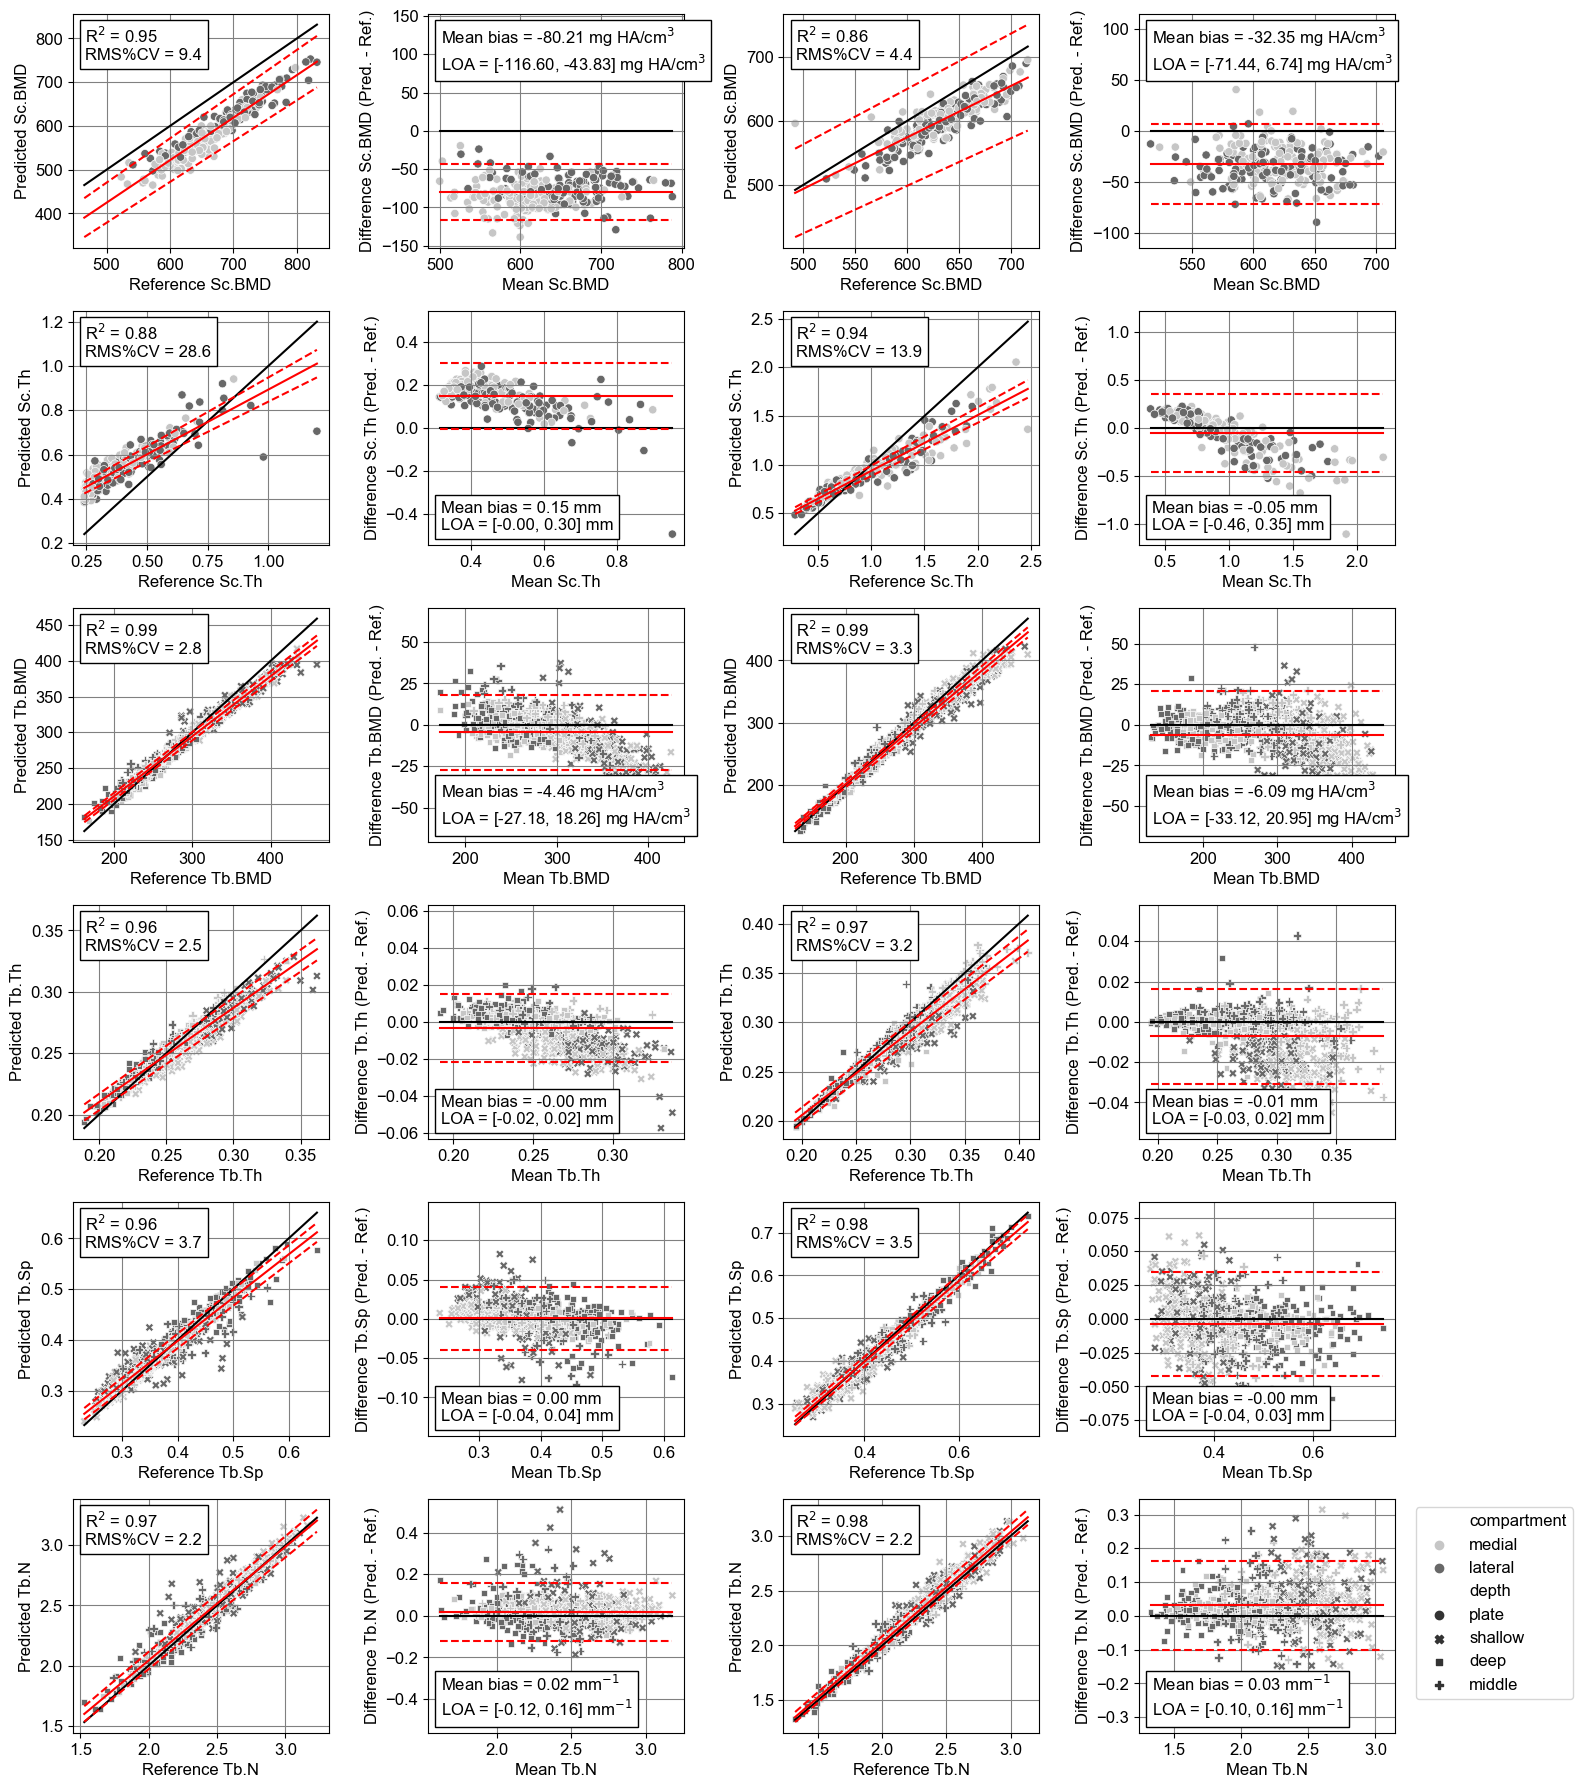

In [18]:
MAX_MOTION = 3

rc = {
    'figure.figsize': (10, 5),
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': 'grey',
    'font.family': 'Arial',
    'font.size': 12,
    'legend.frameon': True,
}
plt.rcParams.update(rc)

ba_lin_reg = False
save_plot = True

palette = "Greys"

text_bbox = {
    "edgecolor": "k",
    "facecolor": "w"
}

units = [
    "mg HA/cm$^3$",
    "mm",
    "mm",
    "mm$^{-1}$"
]

df_subset = df[(df["motion score"] <= MAX_MOTION) | df["motion score"].isna()]

fig, axs = plt.subplots(6, 4, figsize=(16, 18))

for i, p in enumerate(["Sc.BMD", "Sc.Th"]):

    for j, b in enumerate(["F", "T"]):

        sns.scatterplot(
            ax=axs[i][2 * j + 0],
            data=df_subset[df_subset["bone"] == b],
            x=f"Reference {p}",
            y=f"Predicted {p}",
            hue="compartment",
            style="depth",
            palette=palette,
            legend=False
        )

        use_val = (
            ~df_subset[df_subset["bone"] == b][f"Reference {p}"].isna()
            & ~df_subset[df_subset["bone"] == b][f"Reference {p}"].isna()
        )
        
        ref_vals = df_subset[df_subset["bone"] == b][f"Reference {p}"][use_val]
        pred_vals = df_subset[df_subset["bone"] == b][f"Predicted {p}"][use_val]

        minval = min(ref_vals.min(), pred_vals.min())
        maxval = max(ref_vals.max(), pred_vals.max())

        axs[i][2 * j + 0].plot([minval, maxval], [minval, maxval], "k-")

        lin_reg_result = stats.linregress(x=ref_vals, y=pred_vals)
        r_squared = lin_reg_result.rvalue

        minval_fit = minval * lin_reg_result.slope + lin_reg_result.intercept
        maxval_fit = maxval * lin_reg_result.slope + lin_reg_result.intercept

        minval_fit_upp = (
                minval * (lin_reg_result.slope + 1.96 * lin_reg_result.stderr)
                + lin_reg_result.intercept + 1.96 * lin_reg_result.intercept_stderr
        )
        maxval_fit_upp = (
                maxval * (lin_reg_result.slope + 1.96 * lin_reg_result.stderr)
                + lin_reg_result.intercept + 1.96 * lin_reg_result.intercept_stderr
        )

        minval_fit_low = (
                minval * (lin_reg_result.slope - 1.96 * lin_reg_result.stderr)
                + lin_reg_result.intercept - 1.96 * lin_reg_result.intercept_stderr
        )
        maxval_fit_low = (
                maxval * (lin_reg_result.slope - 1.96 * lin_reg_result.stderr)
                + lin_reg_result.intercept - 1.96 * lin_reg_result.intercept_stderr
        )

        axs[i][2 * j + 0].plot([minval, maxval], [minval_fit, maxval_fit], "r-")
        axs[i][2 * j + 0].plot([minval, maxval], [minval_fit_low, maxval_fit_low], "r--")
        axs[i][2 * j + 0].plot([minval, maxval], [minval_fit_upp, maxval_fit_upp], "r--")

        data = [
            np.array([r, p])
            for (r, p) in zip(ref_vals, pred_vals)
        ]
        rms_cv, lsc, rms_pe, _ = calculate_precision(data)

        axs[i][2 * j + 0].text(
            0.05, 0.95,
            f"R$^2$ = {r_squared:0.2f}\nRMS%CV = {rms_cv:0.1f}",
            horizontalalignment='left',
            verticalalignment='top',
            transform=axs[i][2 * j + 0].transAxes,
            bbox=text_bbox
        )

        sns.scatterplot(
            ax=axs[i][2 * j + 1],
            data=df_subset[df_subset["bone"] == b],
            x=f"Mean {p}",
            y=f"Difference {p} (Pred. - Ref.)",
            hue="compartment",
            style="depth",
            palette=palette,
            legend=False
        )

        minval = df_subset[df_subset["bone"] == b][f"Mean {p}"].min()
        maxval = df_subset[df_subset["bone"] == b][f"Mean {p}"].max()

        axs[i][2 * j + 1].plot([minval, maxval], [0, 0], "k-")

        if ba_lin_reg:
            mean_vals = df_subset[df_subset["bone"] == b][f"Mean {p}"].dropna()
            diff_vals = df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].dropna()

            minval = mean_vals.min()
            maxval = mean_vals.max()

            axs[i][2 * j + 1].plot([minval, maxval], [0, 0], "k-")

            lin_reg_result = stats.linregress(x=mean_vals, y=diff_vals)

            minval_fit = minval * lin_reg_result.slope + lin_reg_result.intercept
            maxval_fit = maxval * lin_reg_result.slope + lin_reg_result.intercept

            minval_fit_upp = (
                    minval * (lin_reg_result.slope + 1.96*lin_reg_result.stderr)
                    + lin_reg_result.intercept + 1.96*lin_reg_result.intercept_stderr
            )
            maxval_fit_upp = (
                    maxval * (lin_reg_result.slope + 1.96*lin_reg_result.stderr)
                    + lin_reg_result.intercept + 1.96*lin_reg_result.intercept_stderr
            )

            minval_fit_low = (
                    minval * (lin_reg_result.slope - 1.96*lin_reg_result.stderr)
                    + lin_reg_result.intercept - 1.96*lin_reg_result.intercept_stderr
            )
            maxval_fit_low = (
                    maxval * (lin_reg_result.slope - 1.96*lin_reg_result.stderr)
                    + lin_reg_result.intercept - 1.96*lin_reg_result.intercept_stderr
            )

            axs[i][2 * j + 1].plot([minval, maxval], [minval_fit, maxval_fit], "r-")
            axs[i][2 * j + 1].plot([minval, maxval], [minval_fit_low, maxval_fit_low], "r--")
            axs[i][2 * j + 1].plot([minval, maxval], [minval_fit_upp, maxval_fit_upp], "r--")

        else:

            axs[i][2 * j + 1].set_ylim(
                -1.1*df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].abs().max(),
                1.1*df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].abs().max()
            )

            mean_bias = df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].mean()
            loa_low = mean_bias - 1.96 * df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].std()
            loa_upp = mean_bias + 1.96 * df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].std()

            axs[i][2 * j + 1].plot([minval, maxval], [mean_bias, mean_bias], "r-")
            axs[i][2 * j + 1].plot([minval, maxval], [loa_low, loa_low], "r--")
            axs[i][2 * j + 1].plot([minval, maxval], [loa_upp, loa_upp], "r--")

            axs[i][2 * j + 1].text(
                0.05, 0.05 if i>0 else 0.95,
                f"Mean bias = {mean_bias:0.2f} {units[i]}\nLOA = [{loa_low:0.2f}, {loa_upp:0.2f}] {units[i]}",
                horizontalalignment='left',
                verticalalignment='bottom' if i>0 else "top",
                transform=axs[i][2 * j + 1].transAxes,
                bbox=text_bbox
            )

for i, p in enumerate(["Tb.BMD", "Tb.Th", "Tb.Sp", "Tb.N"]):

    for j, b in enumerate(["F", "T"]):

        sns.scatterplot(
            ax=axs[i + 2][2 * j + 0],
            data=df_subset[df_subset["bone"] == b],
            x=f"Reference {p}",
            y=f"Predicted {p}",
            hue="compartment",
            style="depth",
            palette=palette,
            legend=False
        )

        use_val = (
            ~df_subset[df_subset["bone"] == b][f"Reference {p}"].isna()
            & ~df_subset[df_subset["bone"] == b][f"Reference {p}"].isna()
        )
        
        ref_vals = df_subset[df_subset["bone"] == b][f"Reference {p}"][use_val]
        pred_vals = df_subset[df_subset["bone"] == b][f"Predicted {p}"][use_val]

        minval = min(ref_vals.min(), pred_vals.min())
        maxval = max(ref_vals.max(), pred_vals.max())

        axs[i + 2][2 * j + 0].plot([minval, maxval], [minval, maxval], "k-")

        lin_reg_result = stats.linregress(x=ref_vals, y=pred_vals)

        r_squared = lin_reg_result.rvalue

        minval_fit = minval * lin_reg_result.slope + lin_reg_result.intercept
        maxval_fit = maxval * lin_reg_result.slope + lin_reg_result.intercept

        minval_fit_upp = (
                minval * (lin_reg_result.slope + 1.96*lin_reg_result.stderr)
                + lin_reg_result.intercept + 1.96*lin_reg_result.intercept_stderr
        )
        maxval_fit_upp = (
                maxval * (lin_reg_result.slope + 1.96*lin_reg_result.stderr)
                + lin_reg_result.intercept + 1.96*lin_reg_result.intercept_stderr
        )

        minval_fit_low = (
                minval * (lin_reg_result.slope - 1.96*lin_reg_result.stderr)
                + lin_reg_result.intercept - 1.96*lin_reg_result.intercept_stderr
        )
        maxval_fit_low = (
                maxval * (lin_reg_result.slope - 1.96*lin_reg_result.stderr)
                + lin_reg_result.intercept - 1.96*lin_reg_result.intercept_stderr
        )

        axs[i + 2][2 * j + 0].plot([minval, maxval], [minval_fit, maxval_fit], "r-")
        axs[i + 2][2 * j + 0].plot([minval, maxval], [minval_fit_low, maxval_fit_low], "r--")
        axs[i + 2][2 * j + 0].plot([minval, maxval], [minval_fit_upp, maxval_fit_upp], "r--")

        data = [
            np.array([r, p])
            for (r, p) in zip(ref_vals, pred_vals)
        ]
        rms_cv, lsc, rms_pe, _ = calculate_precision(data)

        axs[i + 2][2 * j + 0].text(
            0.05, 0.95,
            f"R$^2$ = {r_squared:0.2f}\nRMS%CV = {rms_cv:0.1f}",
            horizontalalignment='left',
            verticalalignment='top',
            transform=axs[i + 2][2 * j + 0].transAxes,
            bbox=text_bbox
        )

        sm = sns.scatterplot(
            ax=axs[i + 2][2 * j + 1],
            data=df_subset[df_subset["bone"] == b],
            x=f"Mean {p}",
            y=f"Difference {p} (Pred. - Ref.)",
            hue="compartment",
            style="depth",
            palette=palette,
            legend="brief" if ((i == 3) and (j == 1)) else False
        )

        if ((i == 3) and (j == 1)):
            axs[i + 2][2 * j + 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        minval = df_subset[df_subset["bone"] == b][f"Mean {p}"].min()
        maxval = df_subset[df_subset["bone"] == b][f"Mean {p}"].max()

        axs[i + 2][2 * j + 1].plot([minval, maxval], [0, 0], "k-")

        if ba_lin_reg:
            mean_vals = df_subset[df_subset["bone"] == b][f"Mean {p}"].dropna()
            diff_vals = df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].dropna()

            minval = mean_vals.min()
            maxval = mean_vals.max()

            axs[i + 2][2 * j + 1].plot([minval, maxval], [0, 0], "k-")

            lin_reg_result = stats.linregress(x=mean_vals, y=diff_vals)

            minval_fit = minval * lin_reg_result.slope + lin_reg_result.intercept
            maxval_fit = maxval * lin_reg_result.slope + lin_reg_result.intercept

            minval_fit_upp = (
                    minval * (lin_reg_result.slope + lin_reg_result.stderr)
                    + lin_reg_result.intercept + lin_reg_result.intercept_stderr
            )
            maxval_fit_upp = (
                    maxval * (lin_reg_result.slope + lin_reg_result.stderr)
                    + lin_reg_result.intercept + lin_reg_result.intercept_stderr
            )

            minval_fit_low = (
                    minval * (lin_reg_result.slope - lin_reg_result.stderr)
                    + lin_reg_result.intercept - lin_reg_result.intercept_stderr
            )
            maxval_fit_low = (
                    maxval * (lin_reg_result.slope - lin_reg_result.stderr)
                    + lin_reg_result.intercept - lin_reg_result.intercept_stderr
            )

            axs[i + 2][2 * j + 1].plot([minval, maxval], [minval_fit, maxval_fit], "r-")
            axs[i + 2][2 * j + 1].plot([minval, maxval], [minval_fit_low, maxval_fit_low], "r--")
            axs[i + 2][2 * j + 1].plot([minval, maxval], [minval_fit_upp, maxval_fit_upp], "r--")

        else:

            axs[i + 2][2 * j + 1].set_ylim(
                -1.1*df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].abs().max(),
                1.1*df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].abs().max()
            )

            mean_bias = df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].mean()
            loa_low = mean_bias - 1.96 * df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].std()
            loa_upp = mean_bias + 1.96 * df_subset[df_subset["bone"] == b][f"Difference {p} (Pred. - Ref.)"].std()

            axs[i + 2][2 * j + 1].plot([minval, maxval], [mean_bias, mean_bias], "r-")
            axs[i + 2][2 * j + 1].plot([minval, maxval], [loa_low, loa_low], "r--")
            axs[i + 2][2 * j + 1].plot([minval, maxval], [loa_upp, loa_upp], "r--")

            axs[i + 2][2 * j + 1].text(
                0.05, 0.05,
                f"Mean bias = {mean_bias:0.2f} {units[i]}\nLOA = [{loa_low:0.2f}, {loa_upp:0.2f}] {units[i]}",
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=axs[i + 2][2 * j + 1].transAxes,
                bbox=text_bbox
            )

plt.tight_layout()

if save_plot:
    plt.savefig("test.png", dpi=300, pad_inches=0)

plt.show()

In [19]:
df[df["bone"]=="F"].sort_values(by="Difference Sc.Th (Pred. - Ref.)", ascending=False)

study   roi compartment    depth    id side bone  Reference Sc.Th  \
1419    PREOA  17.0      medial    plate  19.0    L    F         0.284955   
99     CONMED  16.0     lateral    plate  13.0    R    F         0.251370   
154    CONMED  16.0     lateral    plate  23.0    R    F         0.277955   
948    CONMED  16.0     lateral    plate   5.0    R    F         0.289590   
1106   CONMED  16.0     lateral    plate  11.0    R    F         0.298376   
...       ...   ...         ...      ...   ...  ...  ...              ...   
2075  KNEEVAL  15.0      medial     deep   2.0    ?    F              NaN   
2076  KNEEVAL  14.0      medial   middle   2.0    ?    F              NaN   
2077  KNEEVAL  10.0     lateral  shallow  27.0    ?    F              NaN   
2078  KNEEVAL  13.0      medial  shallow   3.0    ?    F              NaN   
2079  KNEEVAL  10.0     lateral  shallow  20.0    ?    F              NaN   

      Reference Sc.BMD  Reference Tb.BMD  ...  \
1419          688.5664               NaN  ...   
99            606.6145               NaN  ...   
154           661.6984               NaN  ...   
948           665.7338               NaN  ...   
1106          642.5300               NaN  ...   
...                ...               ...  ...   
2075               NaN          242.0166  ...   
2076               NaN          293.3010  ...   
2077               NaN          404.2868  ...   
2078               NaN          341.4536  ...   
2079               NaN          307.9817  ...   

      Difference Sc.Th (Pred. - Ref.)  Mean Tb.BMD  \
1419                         0.286373          NaN   
99                           0.266066          NaN   
154                          0.258532          NaN   
948                          0.256270          NaN   
1106                         0.255848          NaN   
...                               ...          ...   
2075                              NaN    242.89745   
2076                              NaN    292.12655   
2077                              NaN    386.37640   
2078                              NaN    346.64075   
2079                              NaN    309.84125   

      Difference Tb.BMD (Pred. - Ref.)  Mean Tb.Th  \
1419                               NaN         NaN   
99                                 NaN         NaN   
154                                NaN         NaN   
948                                NaN         NaN   
1106                               NaN         NaN   
...                                ...         ...   
2075                            1.7617    0.220844   
2076                           -2.3489    0.244463   
2077                          -35.8208    0.293937   
2078                           10.3743    0.288608   
2079                            3.7191    0.258682   

      Difference Tb.Th (Pred. - Ref.)  Mean Tb.N  \
1419                              NaN        NaN   
99                                NaN        NaN   
154                               NaN        NaN   
948                               NaN        NaN   
1106                              NaN        NaN   
...                               ...        ...   
2075                         0.002531   2.215622   
2076                        -0.000892   2.421801   
2077                        -0.017358   2.465189   
2078                        -0.008487   2.309671   
2079                        -0.001871   2.240019   

      Difference Tb.N (Pred. - Ref.)  Mean Tb.Sp  \
1419                             NaN         NaN   
99                               NaN         NaN   
154                              NaN         NaN   
948                              NaN         NaN   
1106                             NaN         NaN   
...                              ...         ...   
2075                        0.001477    0.422886   
2076                       -0.026377    0.362261   
2077                       -0.060134    0.342757   
2078                        0.153153    0.388210   

The largest overestimation of Sc.Th in a femur occurs in PREOA_019_L_XCT_F in the medial compartment, and the difference is 0.28 mm.

In [20]:
df[df["bone"]=="F"].sort_values(by="Difference Sc.Th (Pred. - Ref.)", ascending=True)

study   roi compartment    depth    id side bone  Reference Sc.Th  \
1332    PREOA  17.0      medial    plate  28.0    L    F         1.199662   
893    CONMED  17.0      medial    plate   5.0    R    F         0.979136   
143    CONMED  17.0      medial    plate  23.0    R    F         0.927299   
285    CONMED  17.0      medial    plate   3.0    L    F         0.713795   
929    CONMED  17.0      medial    plate  10.0    R    F         0.711160   
...       ...   ...         ...      ...   ...  ...  ...              ...   
2075  KNEEVAL  15.0      medial     deep   2.0    ?    F              NaN   
2076  KNEEVAL  14.0      medial   middle   2.0    ?    F              NaN   
2077  KNEEVAL  10.0     lateral  shallow  27.0    ?    F              NaN   
2078  KNEEVAL  13.0      medial  shallow   3.0    ?    F              NaN   
2079  KNEEVAL  10.0     lateral  shallow  20.0    ?    F              NaN   

      Reference Sc.BMD  Reference Tb.BMD  ...  \
1332          644.9333               NaN  ...   
893           653.4257               NaN  ...   
143           722.0284               NaN  ...   
285           623.7651               NaN  ...   
929           731.5117               NaN  ...   
...                ...               ...  ...   
2075               NaN          242.0166  ...   
2076               NaN          293.3010  ...   
2077               NaN          404.2868  ...   
2078               NaN          341.4536  ...   
2079               NaN          307.9817  ...   

      Difference Sc.Th (Pred. - Ref.)  Mean Tb.BMD  \
1332                        -0.494215          NaN   
893                         -0.390156          NaN   
143                         -0.105716          NaN   
285                         -0.082483          NaN   
929                         -0.069103          NaN   
...                               ...          ...   
2075                              NaN    242.89745   
2076                              NaN    292.12655   
2077                              NaN    386.37640   
2078                              NaN    346.64075   
2079                              NaN    309.84125   

      Difference Tb.BMD (Pred. - Ref.)  Mean Tb.Th  \
1332                               NaN         NaN   
893                                NaN         NaN   
143                                NaN         NaN   
285                                NaN         NaN   
929                                NaN         NaN   
...                                ...         ...   
2075                            1.7617    0.220844   
2076                           -2.3489    0.244463   
2077                          -35.8208    0.293937   
2078                           10.3743    0.288608   
2079                            3.7191    0.258682   

      Difference Tb.Th (Pred. - Ref.)  Mean Tb.N  \
1332                              NaN        NaN   
893                               NaN        NaN   
143                               NaN        NaN   
285                               NaN        NaN   
929                               NaN        NaN   
...                               ...        ...   
2075                         0.002531   2.215622   
2076                        -0.000892   2.421801   
2077                        -0.017358   2.465189   
2078                        -0.008487   2.309671   
2079                        -0.001871   2.240019   

      Difference Tb.N (Pred. - Ref.)  Mean Tb.Sp  \
1332                             NaN         NaN   
893                              NaN         NaN   
143                              NaN         NaN   
285                              NaN         NaN   
929                              NaN         NaN   
...                              ...         ...   
2075                        0.001477    0.422886   
2076                       -0.026377    0.362261   
2077                       -0.060134    0.342757   
2078                        0.153153    0.388210   

The largest underestimation of Sc.Th in a femur occurs in PREOA_028_L_XCT_F in the medial compartment, and the difference is -0.49 mm.

In [21]:
df[df["bone"]=="T"].sort_values(by="Difference Sc.Th (Pred. - Ref.)", ascending=False)

study   roi compartment    depth    id side bone  Reference Sc.Th  \
1981   PREOA  36.0     lateral    plate  16.0    R    T         0.509410   
1363   PREOA  36.0     lateral    plate  12.0    L    T         0.519996   
166   CONMED  37.0      medial    plate   7.0    L    T         0.595293   
951   CONMED  36.0     lateral    plate  33.0    L    T         0.518152   
538   CONMED  37.0      medial    plate   2.0    R    T         0.411954   
...      ...   ...         ...      ...   ...  ...  ...              ...   
1966   PREOA  34.0      medial   middle  28.0    L    T              NaN   
1974   PREOA  33.0      medial  shallow  12.0    R    T              NaN   
1975   PREOA  35.0      medial     deep  13.0    R    T              NaN   
1978   PREOA  30.0     lateral  shallow  18.0    L    T              NaN   
1982   PREOA  30.0     lateral  shallow  17.0    R    T              NaN   

      Reference Sc.BMD  Reference Tb.BMD  ...  \
1981          536.5608               NaN  ...   
1363          618.1446               NaN  ...   
166           616.5013               NaN  ...   
951           618.1155               NaN  ...   
538           581.1912               NaN  ...   
...                ...               ...  ...   
1966               NaN          364.4636  ...   
1974               NaN          365.0724  ...   
1975               NaN          246.5526  ...   
1978               NaN          377.2491  ...   
1982               NaN          341.1249  ...   

      Difference Sc.Th (Pred. - Ref.)  Mean Tb.BMD  \
1981                         0.249895          NaN   
1363                         0.224373          NaN   
166                          0.222726          NaN   
951                          0.208844          NaN   
538                          0.207572          NaN   
...                               ...          ...   
1966                              NaN    361.41940   
1974                              NaN    363.44885   
1975                              NaN    241.58045   
1978                              NaN    360.60760   
1982                              NaN    336.96450   

      Difference Tb.BMD (Pred. - Ref.)  Mean Tb.Th  \
1981                               NaN         NaN   
1363                               NaN         NaN   
166                                NaN         NaN   
951                                NaN         NaN   
538                                NaN         NaN   
...                                ...         ...   
1966                           -6.0884    0.339824   
1974                           -3.2471    0.302213   
1975                           -9.9443    0.260827   
1978                          -33.2830    0.288038   
1982                           -8.3208    0.282585   

      Difference Tb.Th (Pred. - Ref.)  Mean Tb.N  \
1981                              NaN        NaN   
1363                              NaN        NaN   
166                               NaN        NaN   
951                               NaN        NaN   
538                               NaN        NaN   
...                               ...        ...   
1966                        -0.011833   2.631324   
1974                        -0.016510   2.644745   
1975                        -0.004806   1.990672   
1978                        -0.025757   2.699613   
1982                        -0.019214   2.771301   

      Difference Tb.N (Pred. - Ref.)  Mean Tb.Sp  \
1981                             NaN         NaN   
1363                             NaN         NaN   
166                              NaN         NaN   
951                              NaN         NaN   
538                              NaN         NaN   
...                              ...         ...   
1966                        0.028134    0.337761   
1974                        0.098259    0.344070   
1975                       -0.027012    0.476549   
1978                       -0.048561    0.322320   
1982      

The largest overestimation of Sc.Th in a tibia occurs in PREOA_012_L_XCT_T in the lateral compartment, and the difference is 0.22 mm.

NOTE: We skipped over the first row in the above table because the motion score is 4 (>3).

In [22]:
df[df["bone"]=="T"].sort_values(by="Difference Sc.Th (Pred. - Ref.)", ascending=True)

study   roi compartment    depth    id side bone  Reference Sc.Th  \
1911   PREOA  37.0      medial    plate  28.0    L    T         2.469353   
0     CONMED  37.0      medial    plate   8.0    R    T         1.895573   
1082  CONMED  37.0      medial    plate  35.0    L    T         1.777964   
611   CONMED  37.0      medial    plate  23.0    R    T         1.651602   
321   CONMED  37.0      medial    plate   3.0    R    T         2.119819   
...      ...   ...         ...      ...   ...  ...  ...              ...   
1966   PREOA  34.0      medial   middle  28.0    L    T              NaN   
1974   PREOA  33.0      medial  shallow  12.0    R    T              NaN   
1975   PREOA  35.0      medial     deep  13.0    R    T              NaN   
1978   PREOA  30.0     lateral  shallow  18.0    L    T              NaN   
1982   PREOA  30.0     lateral  shallow  17.0    R    T              NaN   

      Reference Sc.BMD  Reference Tb.BMD  ...  \
1911          623.8270               NaN  ...   
0             637.4857               NaN  ...   
1082          613.0712               NaN  ...   
611           679.6561               NaN  ...   
321           663.7161               NaN  ...   
...                ...               ...  ...   
1966               NaN          364.4636  ...   
1974               NaN          365.0724  ...   
1975               NaN          246.5526  ...   
1978               NaN          377.2491  ...   
1982               NaN          341.1249  ...   

      Difference Sc.Th (Pred. - Ref.)  Mean Tb.BMD  \
1911                        -1.105833          NaN   
0                           -0.677827          NaN   
1082                        -0.605916          NaN   
611                         -0.560123          NaN   
321                         -0.550228          NaN   
...                               ...          ...   
1966                              NaN    361.41940   
1974                              NaN    363.44885   
1975                              NaN    241.58045   
1978                              NaN    360.60760   
1982                              NaN    336.96450   

      Difference Tb.BMD (Pred. - Ref.)  Mean Tb.Th  \
1911                               NaN         NaN   
0                                  NaN         NaN   
1082                               NaN         NaN   
611                                NaN         NaN   
321                                NaN         NaN   
...                                ...         ...   
1966                           -6.0884    0.339824   
1974                           -3.2471    0.302213   
1975                           -9.9443    0.260827   
1978                          -33.2830    0.288038   
1982                           -8.3208    0.282585   

      Difference Tb.Th (Pred. - Ref.)  Mean Tb.N  \
1911                              NaN        NaN   
0                                 NaN        NaN   
1082                              NaN        NaN   
611                               NaN        NaN   
321                               NaN        NaN   
...                               ...        ...   
1966                        -0.011833   2.631324   
1974                        -0.016510   2.644745   
1975                        -0.004806   1.990672   
1978                        -0.025757   2.699613   
1982                        -0.019214   2.771301   

      Difference Tb.N (Pred. - Ref.)  Mean Tb.Sp  \
1911                             NaN         NaN   
0                                NaN         NaN   
1082                             NaN         NaN   
611                              NaN         NaN   
321                              NaN         NaN   
...                              ...         ...   
1966                        0.028134    0.337761   
1974                        0.098259    0.344070   
1975                       -0.027012    0.476549   
1978                       -0.048561    0.322320   
1982      

The largest underestimation of Sc.Th in a tibia occurs in PREOA_028_L_XCT_T in the medial compartment, and the difference is -1.11 mm.

In [29]:
df["Absolute Difference Sc.Th |Pred. - Ref.|"] = df["Difference Sc.Th (Pred. - Ref.)"].apply(np.abs)

In [52]:
def closest_to_median(df, col):
    df = df.copy()
    median = df[col].median()
    df["dist from median"] = np.abs(df[col] - median)
    return df.sort_values(by="dist from median", ascending=True)

In [53]:
closest_to_median(df[df["bone"]=="T"], "Absolute Difference Sc.Th |Pred. - Ref.|")

study   roi compartment    depth    id side bone  Reference Sc.Th  \
159   CONMED  36.0     lateral    plate  15.0    L    T         0.539918   
1128   PREOA  36.0     lateral    plate  24.0    L    T         0.559021   
1736   PREOA  36.0     lateral    plate  33.0    L    T         1.171449   
1548   PREOA  37.0      medial    plate  22.0    L    T         1.102954   
1779   PREOA  36.0     lateral    plate  26.0    R    T         1.010304   
...      ...   ...         ...      ...   ...  ...  ...              ...   
1966   PREOA  34.0      medial   middle  28.0    L    T              NaN   
1974   PREOA  33.0      medial  shallow  12.0    R    T              NaN   
1975   PREOA  35.0      medial     deep  13.0    R    T              NaN   
1978   PREOA  30.0     lateral  shallow  18.0    L    T              NaN   
1982   PREOA  30.0     lateral  shallow  17.0    R    T              NaN   

      Reference Sc.BMD  Reference Tb.BMD  ...  \
159           696.4033               NaN  ...   
1128          614.4916               NaN  ...   
1736          631.5389               NaN  ...   
1548          659.5453               NaN  ...   
1779          658.1248               NaN  ...   
...                ...               ...  ...   
1966               NaN          364.4636  ...   
1974               NaN          365.0724  ...   
1975               NaN          246.5526  ...   
1978               NaN          377.2491  ...   
1982               NaN          341.1249  ...   

      Difference Tb.BMD (Pred. - Ref.)  Mean Tb.Th  \
159                                NaN         NaN   
1128                               NaN         NaN   
1736                               NaN         NaN   
1548                               NaN         NaN   
1779                               NaN         NaN   
...                                ...         ...   
1966                           -6.0884    0.339824   
1974                           -3.2471    0.302213   
1975                           -9.9443    0.260827   
1978                          -33.2830    0.288038   
1982                           -8.3208    0.282585   

      Difference Tb.Th (Pred. - Ref.)  Mean Tb.N  \
159                               NaN        NaN   
1128                              NaN        NaN   
1736                              NaN        NaN   
1548                              NaN        NaN   
1779                              NaN        NaN   
...                               ...        ...   
1966                        -0.011833   2.631324   
1974                        -0.016510   2.644745   
1975                        -0.004806   1.990672   
1978                        -0.025757   2.699613   
1982                        -0.019214   2.771301   

      Difference Tb.N (Pred. - Ref.)  Mean Tb.Sp  \
159                              NaN         NaN   
1128                             NaN         NaN   
1736                             NaN         NaN   
1548                             NaN         NaN   
1779                             NaN         NaN   
...                              ...         ...   
1966                        0.028134    0.337761   
1974                        0.098259    0.344070   
1975                       -0.027012    0.476549   
1978                       -0.048561    0.322320   
1982                        0.099132    0.322075   

      Difference Tb.Sp (Pred. - Ref.)  motion score  \
159                               NaN           1.0   
1128                              NaN           1.0   
1736                              NaN           2.0   
1548                              NaN           1.0   
1779                              NaN           2.0   
...                               ...           ...   
1966                        -0.001652           2.0   
1974                        -0.010589           2.0   
1975                         0.009319           1.0   
1978                         0.021904           1.0   
1

In [56]:
df.iloc[159,:]

study                                          CONMED
roi                                              36.0
compartment                                   lateral
depth                                           plate
id                                               15.0
side                                                L
bone                                                T
Reference Sc.Th                              0.539918
Reference Sc.BMD                             696.4033
Reference Tb.BMD                                  NaN
Reference Tb.N                                    NaN
Reference Tb.Sp                                   NaN
Reference Tb.Th                                   NaN
Predicted Sc.Th                              0.654868
Predicted Sc.BMD                              607.018
Predicted Tb.BMD                                  NaN
Predicted Tb.N                                    NaN
Predicted Tb.Sp                                   NaN
Predicted Tb.Th             

The median error in Sc.Th in the tibia occurs in CONMED 15 LT, the error is +0.11495 mm

In [54]:
closest_to_median(df[df["bone"]=="F"], "Absolute Difference Sc.Th |Pred. - Ref.|")

study   roi compartment    depth    id side bone  Reference Sc.Th  \
1923    PREOA  17.0      medial    plate  12.0    L    F         0.431474   
1179    PREOA  17.0      medial    plate  20.0    R    F         0.333743   
56     CONMED  17.0      medial    plate  25.0    R    F         0.268869   
1623    PREOA  17.0      medial    plate  20.0    L    F         0.329094   
944    CONMED  17.0      medial    plate  19.0    L    F         0.349278   
...       ...   ...         ...      ...   ...  ...  ...              ...   
2075  KNEEVAL  15.0      medial     deep   2.0    ?    F              NaN   
2076  KNEEVAL  14.0      medial   middle   2.0    ?    F              NaN   
2077  KNEEVAL  10.0     lateral  shallow  27.0    ?    F              NaN   
2078  KNEEVAL  13.0      medial  shallow   3.0    ?    F              NaN   
2079  KNEEVAL  10.0     lateral  shallow  20.0    ?    F              NaN   

      Reference Sc.BMD  Reference Tb.BMD  ...  \
1923          706.4255               NaN  ...   
1179          721.2406               NaN  ...   
56            568.8831               NaN  ...   
1623          710.6874               NaN  ...   
944           645.3548               NaN  ...   
...                ...               ...  ...   
2075               NaN          242.0166  ...   
2076               NaN          293.3010  ...   
2077               NaN          404.2868  ...   
2078               NaN          341.4536  ...   
2079               NaN          307.9817  ...   

      Difference Tb.BMD (Pred. - Ref.)  Mean Tb.Th  \
1923                               NaN         NaN   
1179                               NaN         NaN   
56                                 NaN         NaN   
1623                               NaN         NaN   
944                                NaN         NaN   
...                                ...         ...   
2075                            1.7617    0.220844   
2076                           -2.3489    0.244463   
2077                          -35.8208    0.293937   
2078                           10.3743    0.288608   
2079                            3.7191    0.258682   

      Difference Tb.Th (Pred. - Ref.)  Mean Tb.N  \
1923                              NaN        NaN   
1179                              NaN        NaN   
56                                NaN        NaN   
1623                              NaN        NaN   
944                               NaN        NaN   
...                               ...        ...   
2075                         0.002531   2.215622   
2076                        -0.000892   2.421801   
2077                        -0.017358   2.465189   
2078                        -0.008487   2.309671   
2079                        -0.001871   2.240019   

      Difference Tb.N (Pred. - Ref.)  Mean Tb.Sp  \
1923                             NaN         NaN   
1179                             NaN         NaN   
56                               NaN         NaN   
1623                             NaN         NaN   
944                              NaN         NaN   
...                              ...         ...   
2075                        0.001477    0.422886   
2076                       -0.026377    0.362261   
2077                       -0.060134    0.342757   
2078                        0.153153    0.388210   
2079                        0.067194    0.383965   

      Difference Tb.Sp (Pred. - Ref.)  motion score  \
1923                              NaN           2.0   
1179                              NaN           1.0   
56                                NaN           2.0   
1623                              NaN           1.0   
944                               NaN           1.0   
...                               ...           ...   
2075                         0.002479           NaN   
2076                         0.009742           NaN   
2077                         0.036026           NaN   
2078                        -0.043182        

In [57]:
df.iloc[1923,:]

study                                           PREOA
roi                                              17.0
compartment                                    medial
depth                                           plate
id                                               12.0
side                                                L
bone                                                F
Reference Sc.Th                              0.431474
Reference Sc.BMD                             706.4255
Reference Tb.BMD                                  NaN
Reference Tb.N                                    NaN
Reference Tb.Sp                                   NaN
Reference Tb.Th                                   NaN
Predicted Sc.Th                              0.593217
Predicted Sc.BMD                             640.8744
Predicted Tb.BMD                                  NaN
Predicted Tb.N                                    NaN
Predicted Tb.Sp                                   NaN
Predicted Tb.Th             

The median error in Sc.Th in the femur occurs in PREOA 12 LF, the error is +0.161743 mm

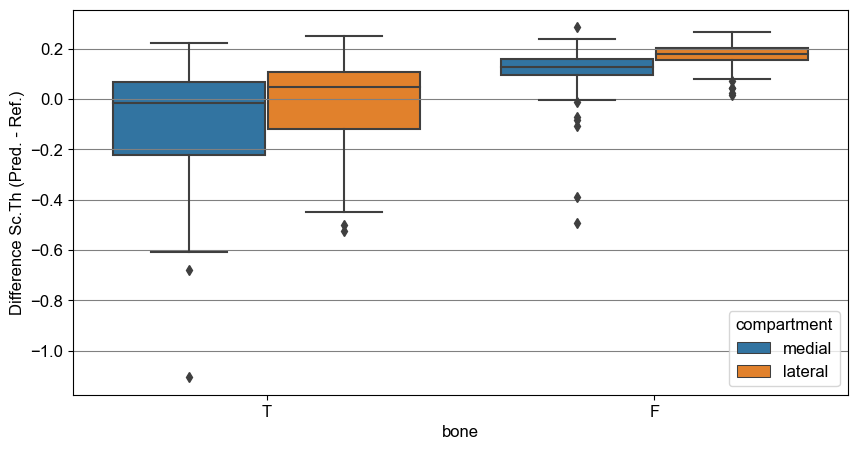

In [24]:
sns.boxplot(
    df,
    x = "bone",
    y = "Difference Sc.Th (Pred. - Ref.)",
    hue = "compartment",
)

plt.show()

In [25]:
df_wide = df.pivot(
    index=["study", "id", "side", "bone", "compartment"],
    columns="depth",
    values=[c for c in df.columns if "Difference" in c]
).dropna(axis=1)

df_wide.columns = df_wide.columns.to_flat_index().map(lambda x: f"{x[0]}, {x[1]}")

df_wide.columns = df_wide.columns.map(lambda x: x.replace("Difference", "").replace("(Pred. - Ref.)", ""))

df_wide

Sc.BMD , plate   Sc.Th , plate  \
study  id   side bone compartment                                    
CONMED 1.0  L    F    lateral             -51.4520        0.178996   
                      medial              -61.9441        0.026136   
                 T    lateral             -36.7226       -0.321986   
                      medial              -31.4764       -0.326828   
            R    F    lateral             -68.8044        0.169289   
...                                            ...             ...   
PREOA  33.0 L    T    medial               40.3859       -0.413205   
            R    F    lateral             -95.7900        0.238678   
                      medial              -65.7541        0.124232   
                 T    lateral             -36.3272       -0.158975   
                      medial              -32.2682       -0.246179   

                                    Tb.BMD , deep   Tb.BMD , middle  \
study  id   side bone compartment                                     
CONMED 1.0  L    F    lateral             -7.6673           -6.2549   
                      medial              -4.2373           -2.8248   
                 T    lateral            -11.0974          -15.7383   
                      medial             -10.8958          -16.9489   
            R    F    lateral            -18.1595          -12.1063   
...                                           ...               ...   
PREOA  33.0 L    T    medial              -9.5384          -20.9033   
            R    F    lateral              0.6089            1.0147   
                      medial              12.1767            7.5089   
                 T    lateral             -1.4206           -1.4206   
                      medial               0.0000          -15.0179   

                                    Tb.BMD , shallow   Tb.Th , deep  \
study  id   side bone compartment                                     
CONMED 1.0  L    F    lateral               -17.7560      -0.002707   
                      medial                -14.9312      -0.001004   
                 T    lateral               -33.2924      -0.000822   
                      medial                -44.5918      -0.003486   
            R    F    lateral               -30.0641      -0.004412   
...                                              ...            ...   
PREOA  33.0 L    T    medial                -25.9770      -0.036032   
            R    F    lateral               -22.9328      -0.000216   
                      medial                -10.1472       0.007087   
                 T    lateral                -5.8854      -0.000902   
                      medial                -27.1946      -0.001718   

                                    Tb.Th , middle   Tb.Th , shallow  \
study  id   side bone compartment                                      
CONMED 1.0  L    F    lateral            -0.001355         -0.013592   
                      medial             -0.000309         -0.012727   
                 T    lateral            -0.001781         -0.025830   
                      medial             -0.006616         -0.028700   
            R    F    lateral            -0.003021         -0.022173   
...                                            ...               ...   
PREOA  33.0 L    T    medial             -0.019950         -0.015624   
            R    F    lateral             0.000320         -0.022275   
                      medial              0.002411         -0.017828   
                 T    lateral             0.002662         -0.004725   
                      medial             -0.008288         -0.009966   

                                    Tb.N , deep   Tb.N , middle  \
study  id   side bone compartment                                 
CONMED 1.0  L    F    lateral         -0.016195       -0.011407   
                      medial          -0.020082       -0.016606   
                 T    lateral         -0.021545       -0.059721   
     

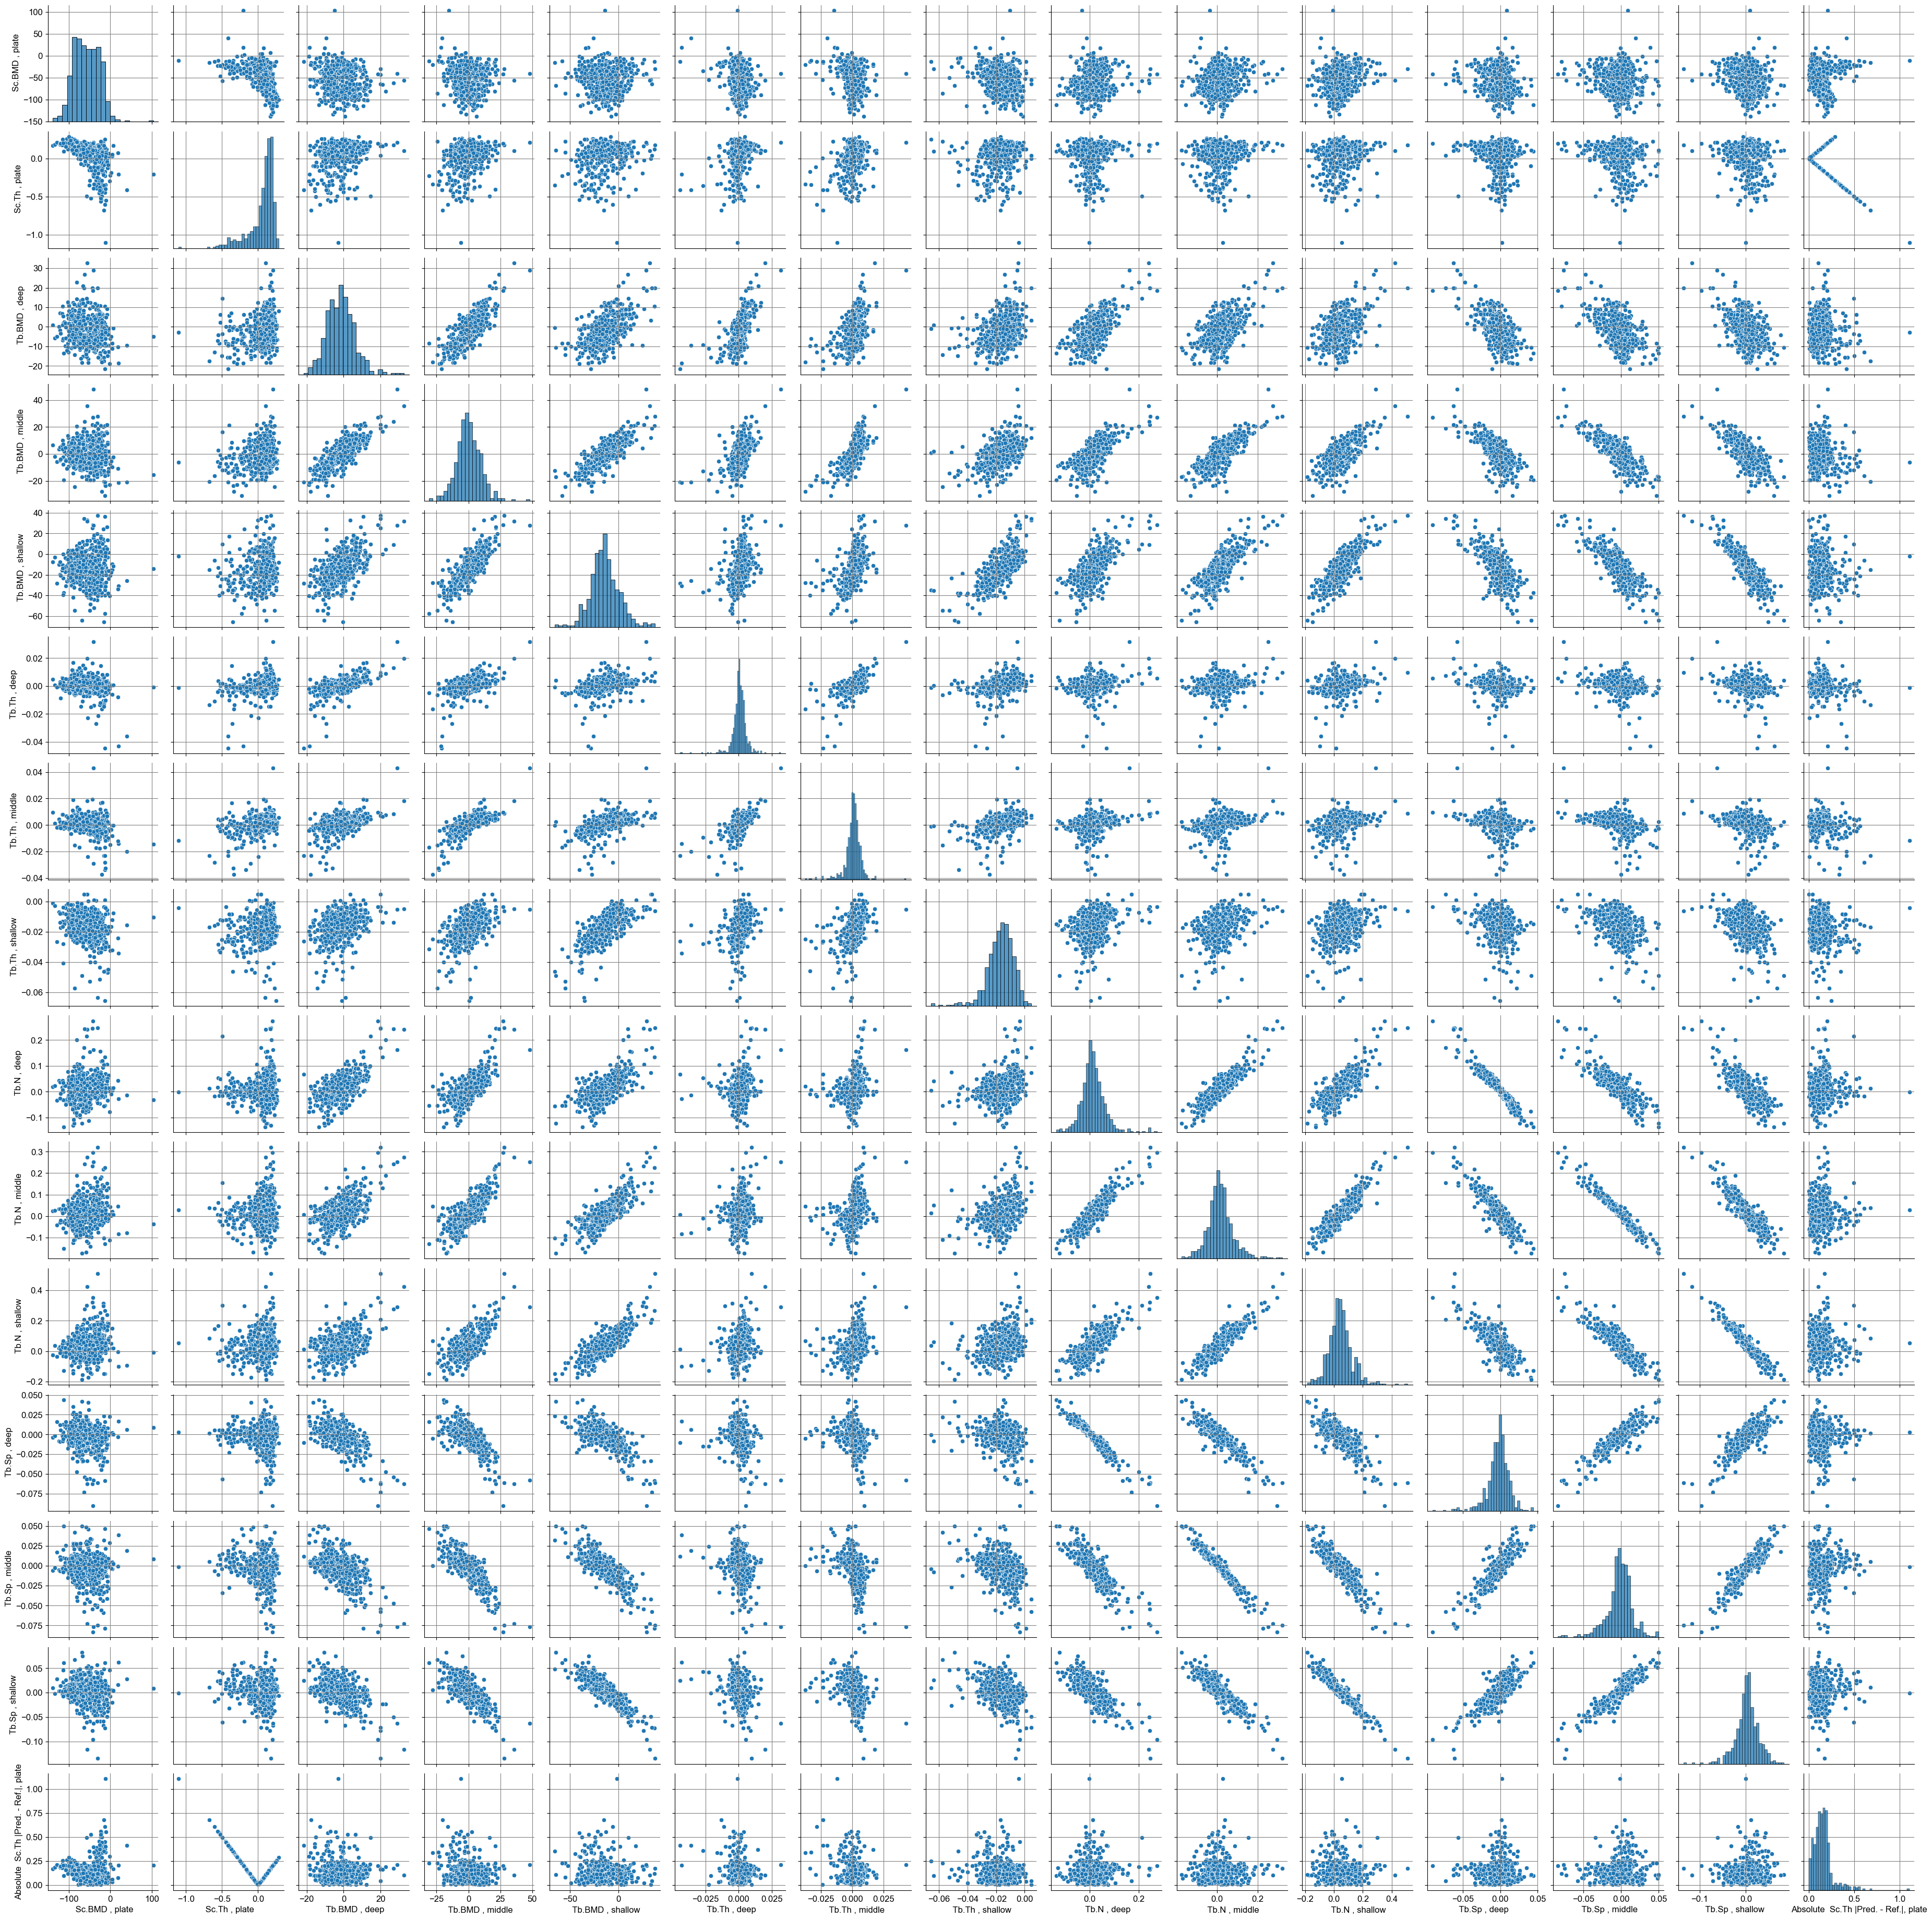

In [26]:
sns.pairplot(df_wide)
plt.show()

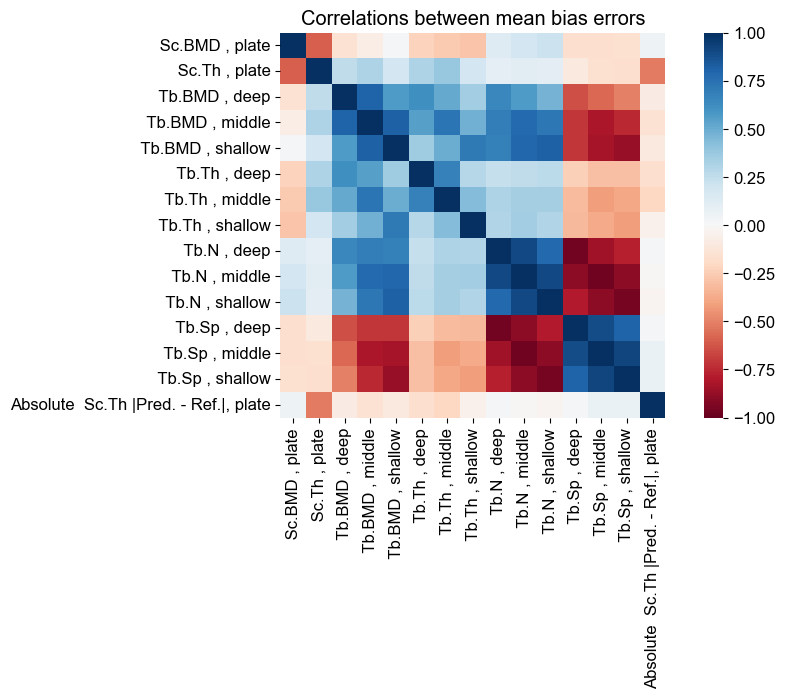

In [27]:
hm = sns.heatmap(
    df_wide.corr(),
    vmin=-1, vmax=1,
    cmap="RdBu",
    square=True,
    #mask = np.triu(df_wide.corr()),
)

plt.title("Correlations between mean bias errors")
plt.show()